# Score Distribution and PDF Analysis

This notebook analyzes the score distributions and probability density functions for embeddings.
It uses the LCA scoring formula: `score = 1 - cosine_distance * 0.5`

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics.pairwise import cosine_distances
from collections import Counter
from scipy.stats import gaussian_kde

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [26]:
# Configuration
SPECIES = 'plainszebra'  # Change this to analyze different species
BASE_PATH = Path('/fs/ess/PAS2136/ggr_data')
RESULTS_PATH = BASE_PATH / 'results' / 'kate' / SPECIES / 'plots'
DATA_PATH = BASE_PATH / 'kate' / 'data_embeddings' / SPECIES

# Create output directory
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

print(f"Analyzing species: {SPECIES}")
print(f"Data path: {DATA_PATH}")
print(f"Results will be saved to: {RESULTS_PATH}")

Analyzing species: plainszebra
Data path: /fs/ess/PAS2136/ggr_data/kate/data_embeddings/plainszebra
Results will be saved to: /fs/ess/PAS2136/ggr_data/results/kate/plainszebra/plots


In [27]:
# Analyze annotation data
def analyze_annotations(species):
    """
    Analyze annotation file to get individual statistics
    """
    annotation_path = DATA_PATH / f'annotations_{species}.json'
    
    try:
        # Load annotations
        with open(annotation_path, 'r') as f:
            annotations_full = json.load(f)
        
        if 'annotations' in annotations_full:
            annotations = annotations_full['annotations']
        else:
            annotations = annotations_full
        
        print(f"Total annotations: {len(annotations)}")
        
        # Check available fields
        if annotations:
            available_fields = list(annotations[0].keys())
            print(f"Available fields: {available_fields}")
            
            # Determine ID field
            if 'name' in available_fields:
                id_field = 'name'
            elif 'individual_id' in available_fields:
                id_field = 'individual_id'
            elif 'individual_uuid' in available_fields:
                id_field = 'individual_uuid'
            else:
                print("Warning: Could not find individual ID field")
                return
            
            print(f"Using field '{id_field}' for individual identification\n")
            
            # Count individuals
            from collections import Counter
            individual_counts = Counter([anno.get(id_field, 'unknown') for anno in annotations])
            
            # Statistics
            print(f"{'='*60}")
            print(f"INDIVIDUAL STATISTICS FOR {species.upper()}")
            print(f"{'='*60}")
            print(f"Total number of unique individuals: {len(individual_counts)}")
            print(f"Total number of annotations: {len(annotations)}")
            print(f"Average annotations per individual: {len(annotations)/len(individual_counts):.2f}")
            print(f"Min annotations per individual: {min(individual_counts.values())}")
            print(f"Max annotations per individual: {max(individual_counts.values())}")
            
            print(f"\n{'='*60}")
            print("TOP 5 INDIVIDUALS WITH MOST ANNOTATIONS:")
            print(f"{'='*60}")
            for i, (individual_id, count) in enumerate(individual_counts.most_common(5), 1):
                print(f"{i}. Individual '{individual_id}': {count} annotations")
            
            # Distribution analysis
            print(f"\n{'='*60}")
            print("ANNOTATION DISTRIBUTION:")
            print(f"{'='*60}")
            
            # Group by count ranges
            ranges = [(1, 1), (2, 2), (3, 5), (6, 10), (11, 20), (21, 50), (51, 100), (101, 1000)]
            for min_val, max_val in ranges:
                individuals_in_range = sum(1 for c in individual_counts.values() if min_val <= c <= max_val)
                if individuals_in_range > 0:
                    if min_val == max_val:
                        print(f"  {min_val} annotation(s): {individuals_in_range} individuals")
                    else:
                        print(f"  {min_val:3d}-{max_val:3d} annotations: {individuals_in_range} individuals")
            
            # Viewpoint analysis if available
            if 'viewpoint' in available_fields:
                viewpoint_counts = Counter([anno.get('viewpoint', 'unknown') for anno in annotations])
                print(f"\n{'='*60}")
                print("VIEWPOINT DISTRIBUTION:")
                print(f"{'='*60}")
                for viewpoint, count in viewpoint_counts.most_common():
                    print(f"  {viewpoint}: {count} annotations ({count/len(annotations)*100:.1f}%)")
            
            return individual_counts
            
    except Exception as e:
        print(f"Error analyzing annotations: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run the analysis
print(f"Analyzing annotations for {SPECIES}...")
print()
individual_counts = analyze_annotations(SPECIES)

Analyzing annotations for plainszebra...

Total annotations: 745
Available fields: ['uuid', 'image_uuid', 'bbox', 'theta', 'viewpoint', 'category_id', 'name', 'name_viewpoint']
Using field 'name' for individual identification

INDIVIDUAL STATISTICS FOR PLAINSZEBRA
Total number of unique individuals: 514
Total number of annotations: 745
Average annotations per individual: 1.45
Min annotations per individual: 1
Max annotations per individual: 5

TOP 5 INDIVIDUALS WITH MOST ANNOTATIONS:
1. Individual 'IBEIS_PZ_0179': 5 annotations
2. Individual 'IBEIS_PZ_1103': 4 annotations
3. Individual 'IBEIS_PZ_1354': 4 annotations
4. Individual 'IBEIS_PZ_0830': 3 annotations
5. Individual 'IBEIS_PZ_0001': 3 annotations

ANNOTATION DISTRIBUTION:
  1 annotation(s): 325 individuals
  2 annotation(s): 151 individuals
    3-  5 annotations: 38 individuals

VIEWPOINT DISTRIBUTION:
  left: 708 annotations (95.0%)
  right: 33 annotations (4.4%)
  : 4 annotations (0.5%)


In [28]:
def load_embeddings_and_calculate_scores(species):
    """
    Load embeddings and annotations to calculate real similarity scores
    using the LCA formula: score = 1 - cosine_distance * 0.5
    """
    try:
        # Paths
        embedding_path = DATA_PATH / f'embeddings_{species}.pickle'
        annotation_path = DATA_PATH / f'annotations_{species}.json'
        
        # Load embeddings
        with open(embedding_path, 'rb') as f:
            embeddings_data = pickle.load(f)
            if isinstance(embeddings_data, tuple):
                embeddings, uuids = embeddings_data
            else:
                embeddings = embeddings_data
                uuids = None
        
        print(f"Loaded {len(embeddings)} embeddings with shape {embeddings.shape}")
        
        # Load annotations  
        with open(annotation_path, 'r') as f:
            annotations_full = json.load(f)
        
        if 'annotations' in annotations_full:
            annotations = annotations_full['annotations']
        else:
            annotations = annotations_full
            
        print(f"Loaded {len(annotations)} annotations")
        
        # Determine the correct field for individual ID
        # Check what fields are available
        available_fields = list(annotations[0].keys())
        print(f"Available fields: {available_fields}")
        
        # Use 'name' for beluga, check for other common fields
        if 'name' in available_fields:
            id_field = 'name'
        elif 'individual_id' in available_fields:
            id_field = 'individual_id'
        elif 'individual_uuid' in available_fields:
            id_field = 'individual_uuid'
        else:
            raise ValueError(f"Cannot find individual ID field. Available: {available_fields}")
        
        print(f"Using field '{id_field}' for individual identification")
        
        # Create mapping from index to individual ID
        names = [anno.get(id_field, 'unknown') for anno in annotations]
        print(names)
        # Verify counts
        if len(embeddings) != len(annotations):
            print(f"Warning: embeddings ({len(embeddings)}) and annotations ({len(annotations)}) count mismatch!")
            min_len = min(len(embeddings), len(annotations))
            embeddings = embeddings[:min_len]
            names = names[:min_len]
        
        # Count individuals
        name_counts = Counter(names)
        print(f"Found {len(name_counts)} unique individuals")
        print(f"Top 5 individuals: {name_counts.most_common(5)}")
        
        # Calculate cosine distances
        print("Calculating cosine distances...")
        cosine_dist = cosine_distances(embeddings)
        
        # Apply LCA scoring formula: score = 1 - cosine_distance * 0.5
        # This maps cosine distance [0, 2] to score [0, 1]
        scores = 1 - cosine_dist * 0.5
        np.fill_diagonal(scores, 0)
        
        # Separate positive and negative scores
        positive_scores, negative_scores = [], []
        n = len(embeddings)
        for i in range(n):
            for j in range(i+1, n):
                score = scores[i, j]
                if names[i] == names[j]:
                    positive_scores.append(score)
                else:
                    negative_scores.append(score)
        
        print(f"Extracted {len(positive_scores)} positive and {len(negative_scores)} negative scores")
        expected_positive = sum(count * (count - 1) // 2 for count in name_counts.values())
        print(f"Expected positive pairs based on counts: {expected_positive}")
        
        # Print statistics
        positive_scores = np.array(positive_scores)
        negative_scores = np.array(negative_scores)
        
        if len(positive_scores) > 0:
            print(f"Positive scores - min: {np.min(positive_scores):.3f}, max: {np.max(positive_scores):.3f}, "
                  f"mean: {np.mean(positive_scores):.3f}, std: {np.std(positive_scores):.3f}")
        if len(negative_scores) > 0:
            print(f"Negative scores - min: {np.min(negative_scores):.3f}, max: {np.max(negative_scores):.3f}, "
                  f"mean: {np.mean(negative_scores):.3f}, std: {np.std(negative_scores):.3f}")
        
        return positive_scores, negative_scores
        
    except Exception as e:
        print(f"Could not load real data for {species}: {e}")
        import traceback
        traceback.print_exc()
        return None, None

In [29]:
# Load the data
positive_scores, negative_scores = load_embeddings_and_calculate_scores(SPECIES)

if positive_scores is not None and negative_scores is not None:
    print(f"\nScore separation (mean_pos - mean_neg): {np.mean(positive_scores) - np.mean(negative_scores):.3f}")
else:
    print("Failed to load scores!")

Loaded 744 embeddings with shape (744, 2152)
Loaded 745 annotations
Available fields: ['uuid', 'image_uuid', 'bbox', 'theta', 'viewpoint', 'category_id', 'name', 'name_viewpoint']
Using field 'name' for individual identification
['IBEIS_PZ_0002', 'IBEIS_PZ_0228', 'IBEIS_PZ_0003', 'IBEIS_PZ_0014', 'IBEIS_PZ_0493', 'IBEIS_PZ_0459', 'IBEIS_PZ_0007', 'IBEIS_PZ_0371', 'IBEIS_PZ_0008', 'IBEIS_PZ_0223', 'IBEIS_PZ_0012', 'IBEIS_PZ_0830', 'IBEIS_PZ_0017', 'IBEIS_PZ_1551', 'IBEIS_PZ_0020', 'IBEIS_PZ_0225', 'IBEIS_PZ_0022', 'IBEIS_PZ_1084', 'IBEIS_PZ_0024', 'IBEIS_PZ_0025', 'IBEIS_PZ_0025', 'IBEIS_PZ_1832', 'IBEIS_PZ_0190', 'IBEIS_PZ_0052', 'IBEIS_PZ_0001', 'IBEIS_PZ_0032', 'IBEIS_PZ_0032', 'IBEIS_PZ_1590', 'IBEIS_PZ_0028', 'IBEIS_PZ_0033', 'IBEIS_PZ_0034', 'IBEIS_PZ_0223', 'IBEIS_PZ_0041', 'IBEIS_PZ_0057', 'IBEIS_PZ_0047', 'IBEIS_PZ_0213', 'IBEIS_PZ_0785', 'IBEIS_PZ_0055', 'IBEIS_PZ_0097', 'IBEIS_PZ_0063', 'IBEIS_PZ_0071', 'IBEIS_PZ_0063', 'IBEIS_PZ_1906', 'IBEIS_PZ_0097', 'IBEIS_PZ_0066', 'IBEI

In [30]:
def plot_score_distribution(pos_scores, neg_scores, species_name, save_path=None):
    """
    Plot score distribution with PDFs and optimal threshold
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Colors
    color_positive = '#2ca02c'
    color_negative = '#d62728'

    # Histograms
    n_bins = 50
    ax.hist(list(neg_scores) + list(pos_scores), density=True, alpha=0.5, color='gray', 
             label=f"All scores", bins=n_bins,edgecolor='gray')
    ax.hist(neg_scores, bins=n_bins, density=True, alpha=0.5, color=color_negative,
             label=f'Negative (n={len(neg_scores):,})', edgecolor='darkred')
    ax.hist(pos_scores, bins=n_bins, density=True, alpha=0.5, color=color_positive,
             label=f'Positive (n={len(pos_scores):,})', edgecolor='darkgreen')

    # KDE PDFs
    xs = np.linspace(0, 1, 300)

    # if len(pos_scores) > 1:
    #     kde_pos = gaussian_kde(pos_scores, bw_method='scott')
    #     pos_density = kde_pos(xs)
    #     ax.plot(xs, pos_density, color='green', linewidth=2, label='Positive PDF', alpha=0.8)

    # if len(neg_scores) > 1:
    #     kde_neg = gaussian_kde(neg_scores, bw_method='scott')
    #     neg_density = kde_neg(xs)
    #     ax.plot(xs, neg_density, color='red', linewidth=2, label='Negative PDF', alpha=0.8)

    # Find optimal threshold by maximizing F1
    best_threshold = 0.5
    best_f1 = 0
    xs_test = np.linspace(0.1, 0.95, 300)

    for thresh in xs_test:
        tp = np.sum(pos_scores >= thresh)
        tn = np.sum(neg_scores < thresh)
        fp = np.sum(neg_scores >= thresh)
        fn = np.sum(pos_scores < thresh)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    ax.axvline(x=best_threshold, color='black', linestyle='--', linewidth=2, alpha=0.7,
               label=f'Optimal threshold: {best_threshold:.3f} (F1={best_f1:.3f})')

    # Stats box
    stats_text = f"Positive: μ={np.mean(pos_scores):.3f}, σ={np.std(pos_scores):.3f}\n"
    stats_text += f"Negative: μ={np.mean(neg_scores):.3f}, σ={np.std(neg_scores):.3f}\n"
    stats_text += f"Separation: {np.mean(pos_scores) - np.mean(neg_scores):.3f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

    ax.set_xlabel('Similarity Score (LCA formula)', fontsize=12)
    ax.set_ylabel('Probability Density', fontsize=12)
    ax.set_title(f'{species_name.capitalize()} - Score Distribution', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1])
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()
    return fig

Plot saved to /fs/ess/PAS2136/ggr_data/results/kate/plainszebra/plots/plainszebra_score_distribution_pdf.png


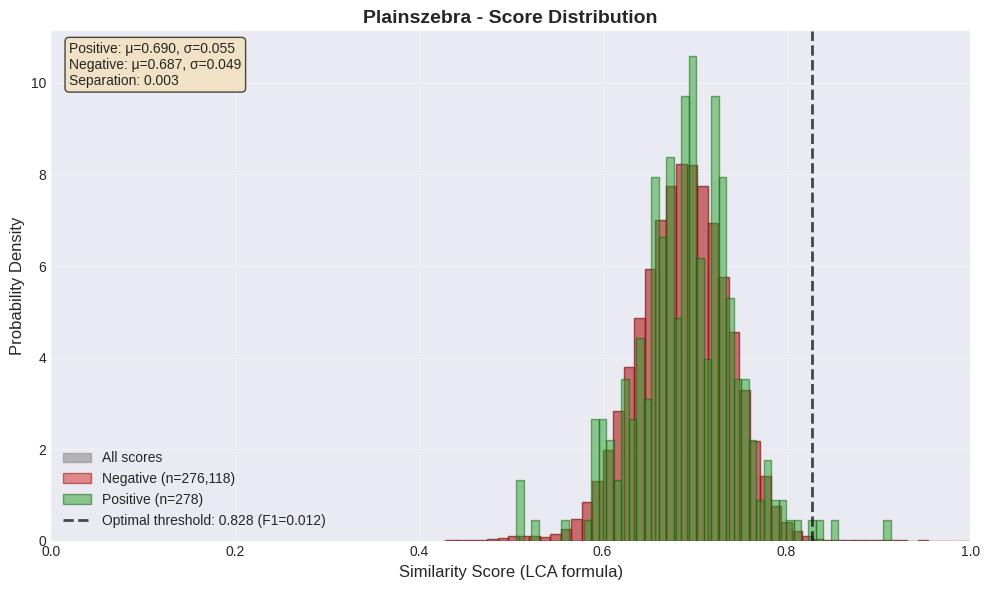

In [31]:
# Generate the score distribution plot
if positive_scores is not None and negative_scores is not None:
    save_path = RESULTS_PATH / f'{SPECIES}_score_distribution_pdf.png'
    fig = plot_score_distribution(positive_scores, negative_scores, SPECIES, save_path)

In [ ]:
# Save scores to mat file
from scipy.io import savemat

if positive_scores is not None and negative_scores is not None:
    # Prepare data dictionary for mat file
    mat_data = {
        'positive_scores': positive_scores,
        'negative_scores': negative_scores,
        'species': SPECIES,
        'num_positive': len(positive_scores),
        'num_negative': len(negative_scores),
        'positive_mean': np.mean(positive_scores),
        'positive_std': np.std(positive_scores),
        'negative_mean': np.mean(negative_scores),
        'negative_std': np.std(negative_scores),
        'separation': np.mean(positive_scores) - np.mean(negative_scores)
    }
    
    # Define output path
    mat_save_path = RESULTS_PATH / f'{SPECIES}_scores.mat'
    # mat_save_path = f'{SPECIES}_scores.mat'
    
    # Save to mat file
    savemat(mat_save_path, mat_data)
    print(f"Scores saved to: {mat_save_path}")
    print(f"  - Positive scores: {len(positive_scores):,} samples")
    print(f"  - Negative scores: {len(negative_scores):,} samples")
    print(f"  - Mean separation: {mat_data['separation']:.3f}")
else:
    print("Cannot save scores - data not loaded successfully")

Scores saved to: plainszebra_scores.mat
  - Positive scores: 278 samples
  - Negative scores: 276,118 samples
  - Mean separation: 0.003
